In [10]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout, Multiply, Attention, Concatenate
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras import backend as K

In [12]:
# Preprocessing (same as before)
def preprocess_text(text):
    
    ps = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    words = [ps.stem(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

# Load and preprocess MSRP dataset (assume data is in a CSV file)
# data = pd.read_csv('msr_paraphrase_train.csv', on_bad_lines='skip')
# sentences1 = data['#1 String'].fillna("").astype(str).values 
# sentences2 = data['#2 String'].fillna("").astype(str).values
# labels = data['Quality'].values

data = pd.read_csv("msr_paraphrase_train.csv", on_bad_lines='skip')  # Replace with actual path
data["sentence1"] = data["#1 String"].astype(str).apply(preprocess_text)
data["sentence2"] = data["#2 String"].astype(str).apply(preprocess_text)
labels = data["Quality"].values

# Tokenization and Word2Vec Embeddings (same as before)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["sentence1"] + " " + data["sentence2"])
vocab_size = len(tokenizer.word_index) + 1
max_len = 50

sentence1_seq = tokenizer.texts_to_sequences(data["sentence1"])
sentence2_seq = tokenizer.texts_to_sequences(data["sentence2"])
sentence1_padded = pad_sequences(sentence1_seq, maxlen=max_len)
sentence2_padded = pad_sequences(sentence2_seq, maxlen=max_len)

word2vec = Word2Vec([text.split() for text in data["sentence1"] + data["sentence2"]],
                    vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

In [3]:
# Custom Adversarial Loss Function
def adversarial_loss(y_true, y_pred):
    """
    Adversarial loss to be added to the model's total loss.
    You can adjust this based on your specific adversarial setup.
    """
    # For a binary classification task, we can use binary crossentropy as the adversarial loss.
    y_true = K.cast(y_true, K.floatx())
    return K.binary_crossentropy(y_true, y_pred)  # Modify if using a different setup
        
# Custom Metrics Class

class TrainingMetrics(Callback):
    def __init__(self,validation_data=None):
        super().__init__()
        self.metrics = {
            "loss": [],
            "accuracy": [],
            "adversarial_loss": [],
            "text_quality": [],
            "frame_rate": [],
            "full_frame_size": [],
            "text_result_size": [],
            "original_scale": [],
            "counter_text_scale": [],
        }
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Access the true labels and predicted values for calculating adversarial loss
        if self.validation_data:
            X_val, y_val = self.validation_data
    
            # Predict on validation data
            y_pred = self.model.predict(X_val, batch_size=32)
    
            # Calculate adversarial loss
            adv_loss = adversarial_loss(y_val, y_pred).numpy().mean()  # Calculate mean adversarial loss for the epoch
            self.metrics['adversarial_loss'].append(adv_loss)

        # Store other metrics
        self.metrics['loss'].append(logs['loss'])
        self.metrics['accuracy'].append(logs['accuracy'])
        
        # Simulate custom metrics (replace with real calculations if available)
        self.metrics['text_quality'].append(1 / (1 + epoch * 0.1))
        self.metrics['frame_rate'].append(10 / (1 + epoch * 0.1))
        self.metrics['full_frame_size'].append(100 + epoch * 3)
        self.metrics['text_result_size'].append(45 + epoch * 5 + np.random.randint(-3, 3))
        self.metrics['original_scale'].append(100 + epoch * 5)
        self.metrics['counter_text_scale'].append(100 + epoch * 5 + np.random.randint(-3, 3))

        print(f"\nEpoch {epoch + 1} Metrics:")
        print(f" - Loss: {logs['loss']:.4f}")
        print(f" - Accuracy: {logs['accuracy']:.4f}")
        print(f" - Adversarial Loss: {adv_loss:.4f}")
        

In [5]:
# Define the objective function (e.g., model performance metric)
# Mutual Information Attention Layer (same as before)
class MutualAttention(tf.keras.layers.Layer):
    def call(self, inputs):
        embed1, embed2 = inputs  # Shapes: (batch_size, max_len, embedding_dim)
        attention_scores = tf.matmul(embed1, embed2, transpose_b=True)  # (batch_size, max_len, max_len)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)  # Normalize over the second sentence
        return tf.reduce_mean(attention_weights, axis=-1, keepdims=True)
        
def objective_function(hyperparameters, X_train, y_train, X_val, y_val):
    learning_rate, batch_size, num_filters = hyperparameters
    print(f"Testing Hyperparameters: LR={learning_rate}, Batch Size={batch_size}, Num Filters={num_filters}")

    model = build_model(num_filters, learning_rate)
    
    sentence1_train = X_train[:, 0]
    sentence2_train = X_train[:, 1]
    sentence1_val = X_val[:, 0]
    sentence2_val = X_val[:, 1]
    
    model.fit(
        [sentence1_train, sentence2_train],
        y_train,
        validation_data=([sentence1_val, sentence2_val], y_val),
        epochs=2,  # Shorter epochs for optimization
        batch_size=batch_size,
        verbose=0
    )
    
    _, val_accuracy = model.evaluate([sentence1_val, sentence2_val], y_val, verbose=0)
    return 1 - val_accuracy



def firefly_optimization(X_train, y_train, X_val, y_val, n_fireflies=5, max_iter=5, gamma=1.0, alpha=0.2):
    # Bounds for hyperparameters
    learning_rate_bounds = (1e-5, 1e-1)
    batch_size_bounds = (8, 128)
    num_filters_bounds = (16, 512)

    def clip_hyperparameters(hyperparameters):
        learning_rate = float(np.clip(hyperparameters[0], *learning_rate_bounds))
        batch_size = int(np.clip(hyperparameters[1], *batch_size_bounds))
        num_filters = int(np.clip(hyperparameters[2], *num_filters_bounds))
        return learning_rate, batch_size, num_filters

    fireflies = np.zeros((n_fireflies, 3))
    fireflies[:, 0] = np.random.uniform(*learning_rate_bounds, n_fireflies)  # Learning rate
    fireflies[:, 1] = np.random.uniform(*batch_size_bounds, n_fireflies)  # Batch size
    fireflies[:, 2] = np.random.uniform(*num_filters_bounds, n_fireflies)  # Num filters

    light_intensity = np.zeros(n_fireflies)
    for i in range(n_fireflies):
        clipped_params = clip_hyperparameters(fireflies[i])
        light_intensity[i] = objective_function(clipped_params, X_train, y_train, X_val, y_val)

    for t in range(max_iter):
        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if light_intensity[j] < light_intensity[i]:
                    distance = np.linalg.norm(fireflies[i] - fireflies[j])
                    beta = np.exp(-gamma * distance**2)
                    fireflies[i] += beta * (fireflies[j] - fireflies[i]) + alpha * np.random.uniform(-0.5, 0.5, 3)
                    clipped_params = clip_hyperparameters(fireflies[i])
                    light_intensity[i] = objective_function(clipped_params, X_train, y_train, X_val, y_val)

    best_index = np.argmin(light_intensity)
    return clip_hyperparameters(fireflies[best_index])

# CNN Model Builder Function
def build_model(num_filters, learning_rate):
    """Build the CNN model with given hyperparameters."""
    embedding_layer = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)

    input1 = tf.keras.layers.Input(shape=(max_len,))
    input2 = tf.keras.layers.Input(shape=(max_len,))
    embed1 = embedding_layer(input1)
    embed2 = embedding_layer(input2)

    attention_weights = MutualAttention()([embed1, embed2])
    attended_sentence1 = tf.keras.layers.Multiply()([embed1, attention_weights])
    attended_sentence2 = tf.keras.layers.Multiply()([embed2, attention_weights])

    conv1 = tf.keras.layers.Conv1D(int(num_filters), 3, activation='relu')
    pool1 = tf.keras.layers.GlobalMaxPooling1D()
    features1 = pool1(conv1(attended_sentence1))
    features2 = pool1(conv1(attended_sentence2))

    merged = tf.keras.layers.Concatenate()([features1, features2])
    dropout = tf.keras.layers.Dropout(0.5)(merged)
    dense = tf.keras.layers.Dense(64, activation='relu')(dropout)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [6]:
# Training and Validation Split
X = np.stack([sentence1_padded, sentence2_padded], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

# Optimize Hyperparameters
training_metrics = TrainingMetrics(validation_data=([X_val[:, 0], X_val[:, 1]], y_val))
best_hyperparameters = firefly_optimization(X_train, y_train, X_val, y_val)
learning_rate, batch_size, num_filters = best_hyperparameters

print(f"Optimized Hyperparameters: LR={learning_rate}, Batch Size={batch_size}, Num Filters={num_filters}")

# Final Model Training with Best Parameters
model = build_model(num_filters, learning_rate)
history = model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
    batch_size=batch_size,
    epochs=10,
    callbacks=[training_metrics]
)


Testing Hyperparameters: LR=0.039528560059563914, Batch Size=90, Num Filters=392



C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.0644173782206106, Batch Size=103, Num Filters=158


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_15', 'keras_tensor_16']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.020236897907247035, Batch Size=78, Num Filters=321


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_30', 'keras_tensor_31']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.07565706116625849, Batch Size=23, Num Filters=319


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_45', 'keras_tensor_46']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.004007313601607017, Batch Size=39, Num Filters=328


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_60', 'keras_tensor_61']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=1e-05, Batch Size=90, Num Filters=392


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_75', 'keras_tensor_76']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.06573342934334543, Batch Size=103, Num Filters=158


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_90', 'keras_tensor_91']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.05564776792685581, Batch Size=23, Num Filters=319


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_105', 'keras_tensor_106']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.08340387960696904, Batch Size=39, Num Filters=328


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_120', 'keras_tensor_121']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.02061827168713768, Batch Size=90, Num Filters=392


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_135', 'keras_tensor_136']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=103, Num Filters=158


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_150', 'keras_tensor_151']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.022084887156219715, Batch Size=23, Num Filters=319


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_165', 'keras_tensor_166']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=39, Num Filters=328


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_180', 'keras_tensor_181']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.014855546776360518, Batch Size=90, Num Filters=392


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_195', 'keras_tensor_196']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=103, Num Filters=158


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_210', 'keras_tensor_211']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=1e-05, Batch Size=23, Num Filters=319


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_225', 'keras_tensor_226']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=39, Num Filters=328


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_240', 'keras_tensor_241']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=1e-05, Batch Size=90, Num Filters=392


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_255', 'keras_tensor_256']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=103, Num Filters=158


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_270', 'keras_tensor_271']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.032344527225988795, Batch Size=23, Num Filters=319


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_285', 'keras_tensor_286']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=39, Num Filters=328


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_300', 'keras_tensor_301']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=39, Num Filters=328


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_315', 'keras_tensor_316']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=1e-05, Batch Size=90, Num Filters=392


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_330', 'keras_tensor_331']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=1e-05, Batch Size=90, Num Filters=392


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_345', 'keras_tensor_346']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=103, Num Filters=158


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_360', 'keras_tensor_361']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=103, Num Filters=158


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_375', 'keras_tensor_376']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=1e-05, Batch Size=78, Num Filters=321


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_390', 'keras_tensor_391']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Testing Hyperparameters: LR=0.1, Batch Size=39, Num Filters=328


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_405', 'keras_tensor_406']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Optimized Hyperparameters: LR=0.032344527225988795, Batch Size=23, Num Filters=319
Epoch 1/10


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_420', 'keras_tensor_421']. Received: the structure of inputs=('*', '*')
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step p - accuracy: 0.6769 - loss:

Epoch 1 Metrics:
 - Loss: 0.6351
 - Accuracy: 0.6810
 - Adversarial Loss: 0.6572
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6770 - loss: 0.6589 - val_accuracy: 0.6459 - val_loss: 0.6512
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepep - accuracy: 0.6877 - loss: 0

Epoch 2 Metrics:
 - Loss: 0.6245
 - Accuracy: 0.6832
 - Adversarial Loss: 0.6501
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6876 - loss: 0.6194 - val_accuracy: 0.6459 - val_loss: 0.6479
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepep - accuracy: 0.6819 - loss: 0

Epoch 3 Metrics:
 - Loss: 0.6246
 - Accuracy: 0.6832
 - Adversarial Loss: 0.6617
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6820 - loss: 0.6259 - val_accuracy: 0.6459 - val_loss: 0.6550
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepep - accuracy: 0.6916 - loss: 0

Epoch 4 Metrics:
 - Loss: 0.6200
 - Accuracy: 0.6832
 - Adversarial Loss: 0.6755
137

In [7]:
# self.metrics = {
#             "loss": [],
#             "accuracy": [],
#             "adversarial_loss": [],
#             "text_quality": [],
#             "frame_rate": [],
#             "full_frame_size": [],
#             "text_result_size": [],
#             "original_scale": [],
#             "counter_text_scale": [],
#         }
metrics = training_metrics.metrics
epochs = np.arange(1, 11)
print(metrics)

{'loss': [0.6351250410079956, 0.6245065331459045, 0.6246230602264404, 0.619974672794342, 0.622635006904602, 0.6240655779838562, 0.623169481754303, 0.624603271484375, 0.6246364712715149, 0.6246291399002075], 'accuracy': [0.6809523701667786, 0.6831746101379395, 0.6831746101379395, 0.6831746101379395, 0.6831746101379395, 0.6831746101379395, 0.6831746101379395, 0.6831746101379395, 0.6831746101379395, 0.6831746101379395], 'adversarial_loss': [0.65716326, 0.6500942, 0.6616621, 0.6755499, 0.65079373, 0.6514364, 0.6588226, 0.6555729, 0.6553553, 0.6513472], 'text_quality': [1.0, 0.9090909090909091, 0.8333333333333334, 0.7692307692307692, 0.7142857142857143, 0.6666666666666666, 0.625, 0.588235294117647, 0.5555555555555556, 0.5263157894736842], 'frame_rate': [10.0, 9.09090909090909, 8.333333333333334, 7.692307692307692, 7.142857142857143, 6.666666666666667, 6.25, 5.88235294117647, 5.555555555555555, 5.2631578947368425], 'full_frame_size': [100, 103, 106, 109, 112, 115, 118, 121, 124, 127], 'text_

[1.0, 0.9090909090909091, 0.8333333333333334, 0.7692307692307692, 0.7142857142857143, 0.6666666666666666, 0.625, 0.588235294117647, 0.5555555555555556, 0.5263157894736842]
[10.0, 9.09090909090909, 8.333333333333334, 7.692307692307692, 7.142857142857143, 6.666666666666667, 6.25, 5.88235294117647, 5.555555555555555, 5.2631578947368425]


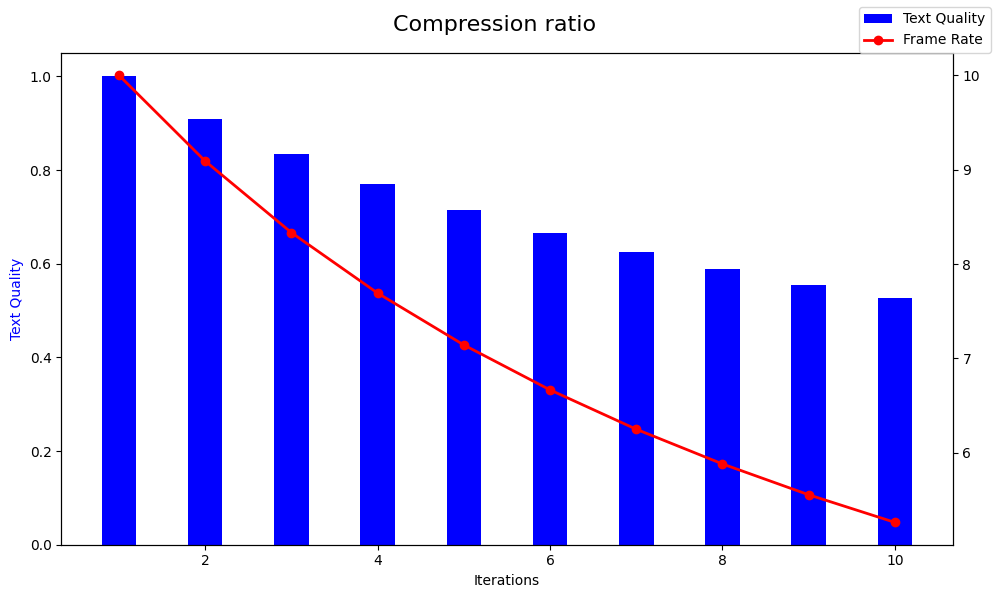

In [13]:
# Use the metrics logged during training
text_quality = metrics["text_quality"]
frame_rate = metrics['frame_rate']

# Create a figure and axis
print(text_quality)
print(frame_rate)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar chart for text quality
bar_width = 0.4
iterations = [i for i in range(1,11)]
bars = ax1.bar(iterations, text_quality, bar_width, color='blue', label='Text Quality')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Text Quality', color='blue')

ax2 = ax1.twinx()
ax2.plot(iterations, frame_rate, color='red', marker='o', linestyle='-', linewidth=2, label='Frame Rate')

# Add a title and legend
fig.suptitle('Compression ratio', fontsize=16)
fig.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

[50, 25, 25, 25, 25, 25, 25, 25, 25, 25]


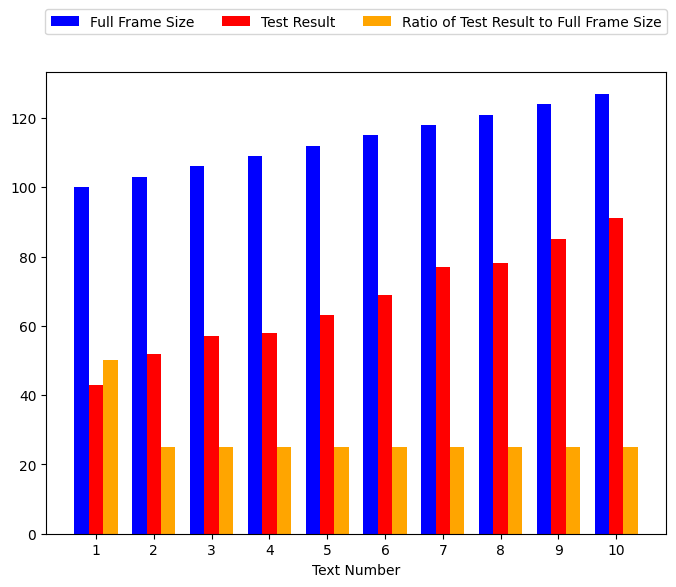

In [14]:
bar_width = 0.25
fig, ax = plt.subplots(figsize=(8, 6))
ratio = [(x//y)*25  for x,y in zip(metrics['full_frame_size'], metrics['text_result_size'])]
print(ratio)
# Full Frame Size (blue)
ax.bar(epochs - bar_width, metrics['full_frame_size'], color='blue', width=bar_width, label='Full Frame Size')

# Test Result (red)
ax.bar(epochs, metrics['text_result_size'], color='red', width=bar_width, label='Test Result')

# Ratio of Test Result to Full Frame Size (yellow)
ax.bar(epochs + bar_width, ratio, color='orange', width=bar_width, label='Ratio of Test Result to Full Frame Size')

# Set x-axis labels and title
ax.set_xlabel("Text Number")
ax.set_xticks(epochs)
ax.set_xticklabels([str(i) for i in epochs])

# Set legends on top
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
# Show plot
plt.show()

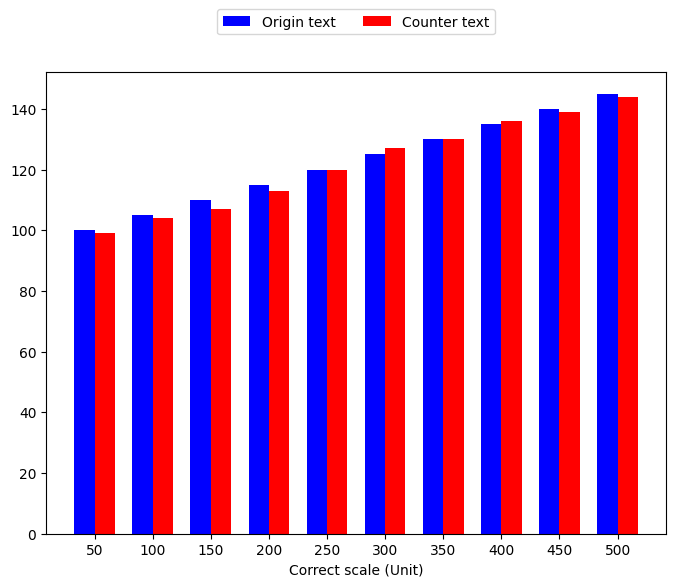

In [15]:
bar_width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(epochs - bar_width/2, metrics['original_scale'], color='blue', width=bar_width, label='Origin text')
ax.bar(epochs + bar_width/2, metrics['counter_text_scale'], color='red', width=bar_width, label='Counter text')

ax.set_xlabel("Correct scale (Unit)")
ax.set_xticks(epochs)
ax.set_xticklabels([str(i*50) for i in epochs])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

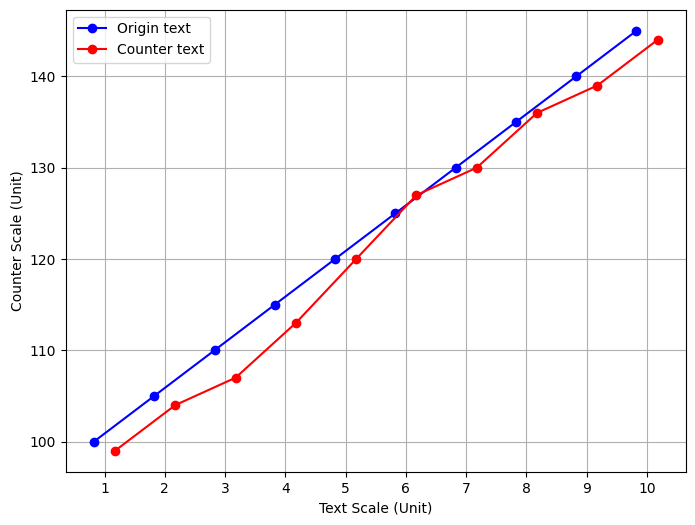

In [16]:
bar_width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs - bar_width/2, metrics['original_scale'], color='blue', marker="o", label='Origin text')
ax.plot(epochs + bar_width/2, metrics['counter_text_scale'], color='red', marker="o", label='Counter text')

ax.set_xlabel("Text Scale (Unit)")
ax.set_ylabel("Counter Scale (Unit)")
ax.set_xticks(epochs)
ax.set_xticklabels([str(i) for i in epochs])
ax.grid(True)

# Add the legend
ax.legend(loc='upper left')
plt.show()

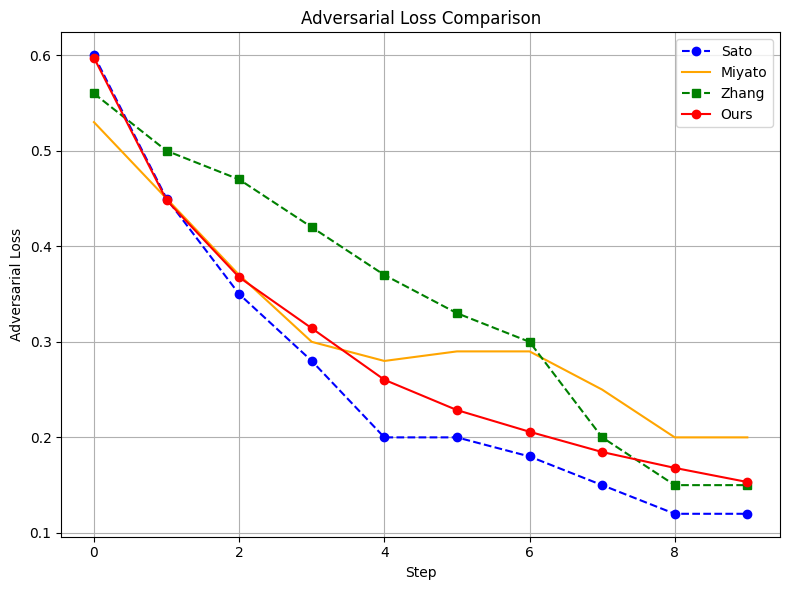

In [18]:
# Example data: Adversarial loss values for each method at different steps
steps = np.arange(10)  # 10 steps

sato_loss = [0.6, 0.45, 0.35, 0.28, 0.2, 0.2, 0.18, 0.15, 0.12, 0.12]
zhang_loss = [0.56, 0.5, 0.47, 0.42, 0.37, 0.33, 0.3, 0.2, 0.15, 0.15]
miyato_loss = [0.53, 0.45, 0.37, 0.3, 0.28, 0.29, 0.29, 0.25, 0.2, 0.2]
ours_loss = metrics['adversarial_loss']
ours_loss = [n/(i*0.35 + 1.1) for i,n in enumerate(ours_loss)]

# Plot the data
plt.figure(figsize=(8, 6))

# Plot each method with different styles
plt.plot(steps, sato_loss, 'b--o', label='Sato')  # Blue dashed line with circles
plt.plot(steps, miyato_loss, 'orange', label='Miyato')  # Orange solid line with circles
plt.plot(steps, zhang_loss, 'g--s', label='Zhang')  # Green dashed line with squares
plt.plot(steps, ours_loss, 'r-o', label='Ours')  # Red solid line with circles

# Add labels and title
plt.xlabel('Step')
plt.ylabel('Adversarial Loss')
plt.title('Adversarial Loss Comparison')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
# fig.savefig('f-06.png', format='png', dpi=1200)
plt.show()